In [1]:
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
# Load the datasets
customers = pd.read_csv('Customers.csv')
transactions = pd.read_csv('Transactions.csv')

In [7]:
# Prepare the data for clustering
# Aggregate transactional data by customer
customer_data = transactions.groupby("CustomerID").agg(TotalTransactions=("TransactionID", "count"),TotalQuantity=("Quantity", "sum"),TotalValue=("TotalValue", "sum")).merge(customers.set_index("CustomerID"), on="CustomerID")

In [9]:
# Encode Region as a numeric value
customer_data["Region"] = customer_data["Region"].astype("category").cat.codes

In [19]:
# Select features for clustering
clustering_features = customer_data[["TotalTransactions", "TotalQuantity", "TotalValue", "Region"]]
clustering_features

,TotalTransactions,TotalQuantity,TotalValue,Region
CustomerID,,,,
C0001,5,12,3354.52,3
C0002,4,10,1862.74,0
C0003,4,14,2725.38,3
C0004,8,23,5354.88,3
C0005,3,7,2034.24,0
...,...,...,...,...
C0196,4,12,4982.88,1
C0197,3,9,1928.65,1
C0198,2,3,931.83,1


In [17]:
# Standardize the data
scaler = StandardScaler()
scaled_features = scaler.fit_transform(clustering_features)
scaled_features

array([[-0.01145819, -0.12203296, -0.06170143,  1.23740234],
       [-0.46749414, -0.44800021, -0.87774353, -1.41989693],
       [-0.46749414,  0.20393428, -0.40585722,  1.23740234],
       [ 1.35664965,  1.67078689,  1.03254704,  1.23740234],
       [-0.92353008, -0.93695108, -0.78392861, -1.41989693],
       [-0.46749414, -0.12203296,  0.41587942,  1.23740234],
       [-0.92353008, -0.77396745, -0.48548229, -1.41989693],
       [ 2.26872154,  1.18183602,  0.43997044,  0.35163592],
       [-0.92353008, -1.58888557, -1.40630171, -0.53413051],
       [-0.46749414, -0.12203296, -0.9571662 , -0.53413051],
       [-0.01145819,  0.04095066,  0.14369581,  1.23740234],
       [ 0.9006137 ,  1.0188524 ,  0.96492372,  1.23740234],
       [ 0.9006137 ,  0.85586877,  1.38575064,  1.23740234],
       [-1.83560198, -1.75186919, -1.72239508, -0.53413051],
       [-1.37956603, -1.42590195, -1.26353893,  0.35163592],
       [-0.01145819, -0.44800021,  0.22269727,  0.35163592],
       [ 1.35664965,  1.

In [35]:
# Find the optimal number of clusters using the Elbow Method

range_clusters = range(2, 11)  # Between 2 and 10 clusters
inertia = []

In [37]:
print("Number of clusters (x):", len(range_clusters))
print("Inertia values (y):", len(inertia))

Number of clusters (x): 9
Inertia values (y): 0


In [39]:
import warnings
warnings.filterwarnings("ignore")

In [41]:
for k in range_clusters:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(scaled_features)
    inertia.append(kmeans.inertia_)

In [42]:
print("Range of Clusters:", list(range_clusters))
print("Inertia Values:", inertia)

Range of Clusters: [2, 3, 4, 5, 6, 7, 8, 9, 10]
Inertia Values: [441.0315284531474, 333.7586236347223, 270.1126948582322, 216.61362052484606, 185.21950678906302, 161.63163709602435, 143.0025240411706, 129.13312417686933, 118.44467359623378]


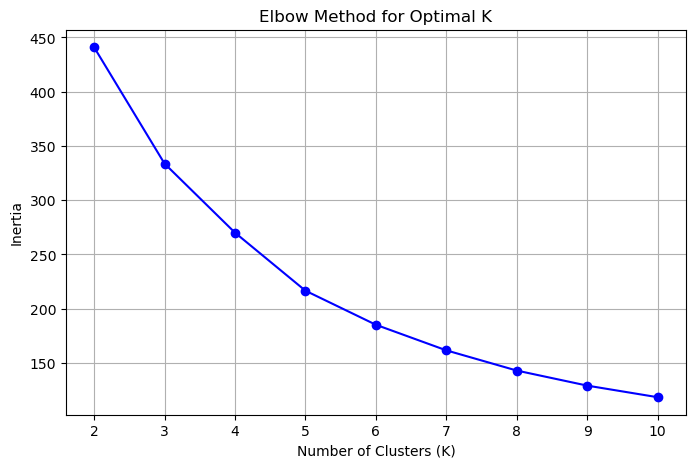

In [45]:
plt.figure(figsize=(8, 5))
plt.plot(range_clusters, inertia, marker="o", linestyle="-", color="b")
plt.title("Elbow Method for Optimal K")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Inertia")
plt.grid(True)
plt.show()

In [47]:
# Choose the optimal number of clusters based on the elbow curve
optimal_k = 4

In [49]:
# Perform KMeans clustering
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
customer_data["Cluster"] = kmeans.fit_predict(scaled_features)

In [51]:
# Calculate Davies-Bouldin Index
db_index = davies_bouldin_score(scaled_features, customer_data["Cluster"])
print(f"Davies-Bouldin Index (DB Index): {db_index}")

Davies-Bouldin Index (DB Index): 1.0092166176966875


In [53]:
# Perform PCA to reduce dimensionality for visualization
pca = PCA(n_components=2)
pca_features = pca.fit_transform(scaled_features)

In [55]:
# Add PCA components to the customer data for visualization
customer_data["PCA1"] = pca_features[:, 0]
customer_data["PCA2"] = pca_features[:, 1]

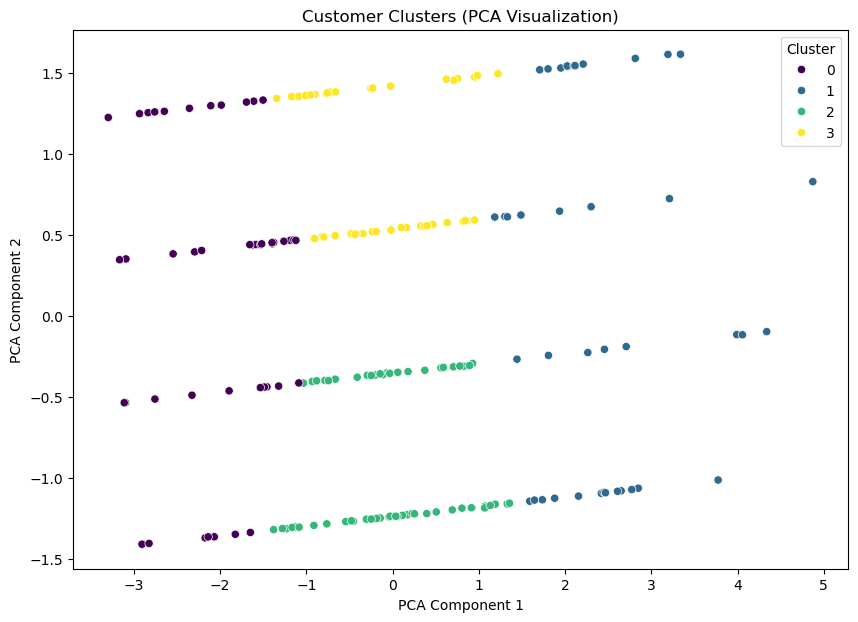

In [57]:
# Visualize clusters in reduced PCA space
plt.figure(figsize=(10, 7))
sns.scatterplot(x=customer_data["PCA1"],y=customer_data["PCA2"],hue=customer_data["Cluster"],palette="viridis",legend="full")
plt.title("Customer Clusters (PCA Visualization)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title="Cluster")
plt.show()

In [65]:
# Summary of clusters
cluster_summary = customer_data.groupby("Cluster").agg(AvgTransactions=("TotalTransactions", "mean"),AvgQuantity=("TotalQuantity", "mean"),AvgTotalValue=("TotalValue", "mean"),RegionMode=("Region", lambda x: x.mode()[0]) ) # Most common region in each cluster

In [67]:
print("Cluster Summary:")
print(cluster_summary)

Cluster Summary:
         AvgTransactions  AvgQuantity  AvgTotalValue  RegionMode
Cluster                                                         
0               2.391304     5.456522    1375.533261           1
1               7.975610    21.634146    6035.840000           3
2               5.121212    12.530303    3368.056667           3
3               4.891304    12.434783    3412.170652           1
